In [241]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa

In [242]:
ABS_PATH = os.path.dirname(os.path.dirname(os.path.abspath("")))
SRC_PATH = os.path.join(ABS_PATH, "static", "audios", "0_src")
OUT_PATH = os.path.join(ABS_PATH, "static", "audios", "1_noise_reduced")

In [481]:
class AudioWorker():
    
    def __init__(self, audio_path):
        self.audio_path = audio_path
        
        self.sample_rate, self.samples = wavfile.read(audio_path)
        if len(self.samples.shape)==2:
            self.samples = np.array(self.samples[:,0], dtype=float)
        else: self.samples = np.array(self.samples, dtype=float)
        
    def get_mel_specs(self):
        specs = librosa.feature.melspectrogram(y=self.samples, sr=self.sample_rate, n_mels=128,
                                   fmax=14000)
        specs_dB = librosa.power_to_db(specs, ref=np.max)
        return specs_dB
                
                
                
    def plot_onsets(self, save_fig=False):
        
        o_env = librosa.onset.onset_strength(y=self.samples, sr=self.sample_rate)
        times = librosa.times_like(o_env, sr=self.sample_rate)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=self.sample_rate)
        
        
        fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(16,6))
        librosa.display.specshow(self.get_mel_specs(),
                                x_axis='time', y_axis='mel', ax=ax[0], sr=self.sample_rate)
        ax[1].plot(times, o_env, label="Onset strength", alpha=0.9)
        ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        ax[1].legend()
        plt.suptitle(os.path.basename(self.audio_path))
        ax[2].plot(times, self.get_mel_specs().mean(axis=0))
        ax[3].plot(times, self.get_mel_specs().var(axis=0))
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}.png")
        
    
    
    def plot_mel_spec(self, specs, save_fig=False):
        
        
        fig, ax = plt.subplots(nrows=4, figsize=(16,16), sharex=True)
        spec_diffs = np.zeros_like(specs)
        # spec_diffs[:, :-1] -= (specs[:, :-1] * specs[:, 1:])**0.5
        spec_diffs[:, :-1] += (specs[:, :-1] - specs[:, 1:])**2


        img = librosa.display.specshow(self.get_mel_specs(),
                                        x_axis='time', y_axis='mel', ax=ax[0], sr=self.sample_rate)
        librosa.display.specshow(spec_diffs,
                                        x_axis='time', y_axis='mel', ax=ax[1], sr=self.sample_rate)
        ax[0].set_title("Mel spectogram")
        ax[1].set_title("1th differentiation")

        times = librosa.times_like(specs, sr=self.sample_rate)

        ax[2].plot(times, spec_diffs.mean(axis=0))
        ax[2].set_title("mean axis 0")
        ax[3].plot(times, np.convolve(spec_diffs.mean(axis=0), np.ones(15)*1/15, mode="same"))
        ax[3].set_title("Moving average")

        ax[0].vlines(times[np.where(spec_diffs.mean(axis=0)>spec_diffs.mean())], 0, 1000)
        ax[0].scatter(times, specs.argmax(axis=0)**2, s=1, color="y", alpha=1)

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.suptitle(os.path.basename(self.audio_path))

        # plt.ylim(1024)
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-1.png")
        

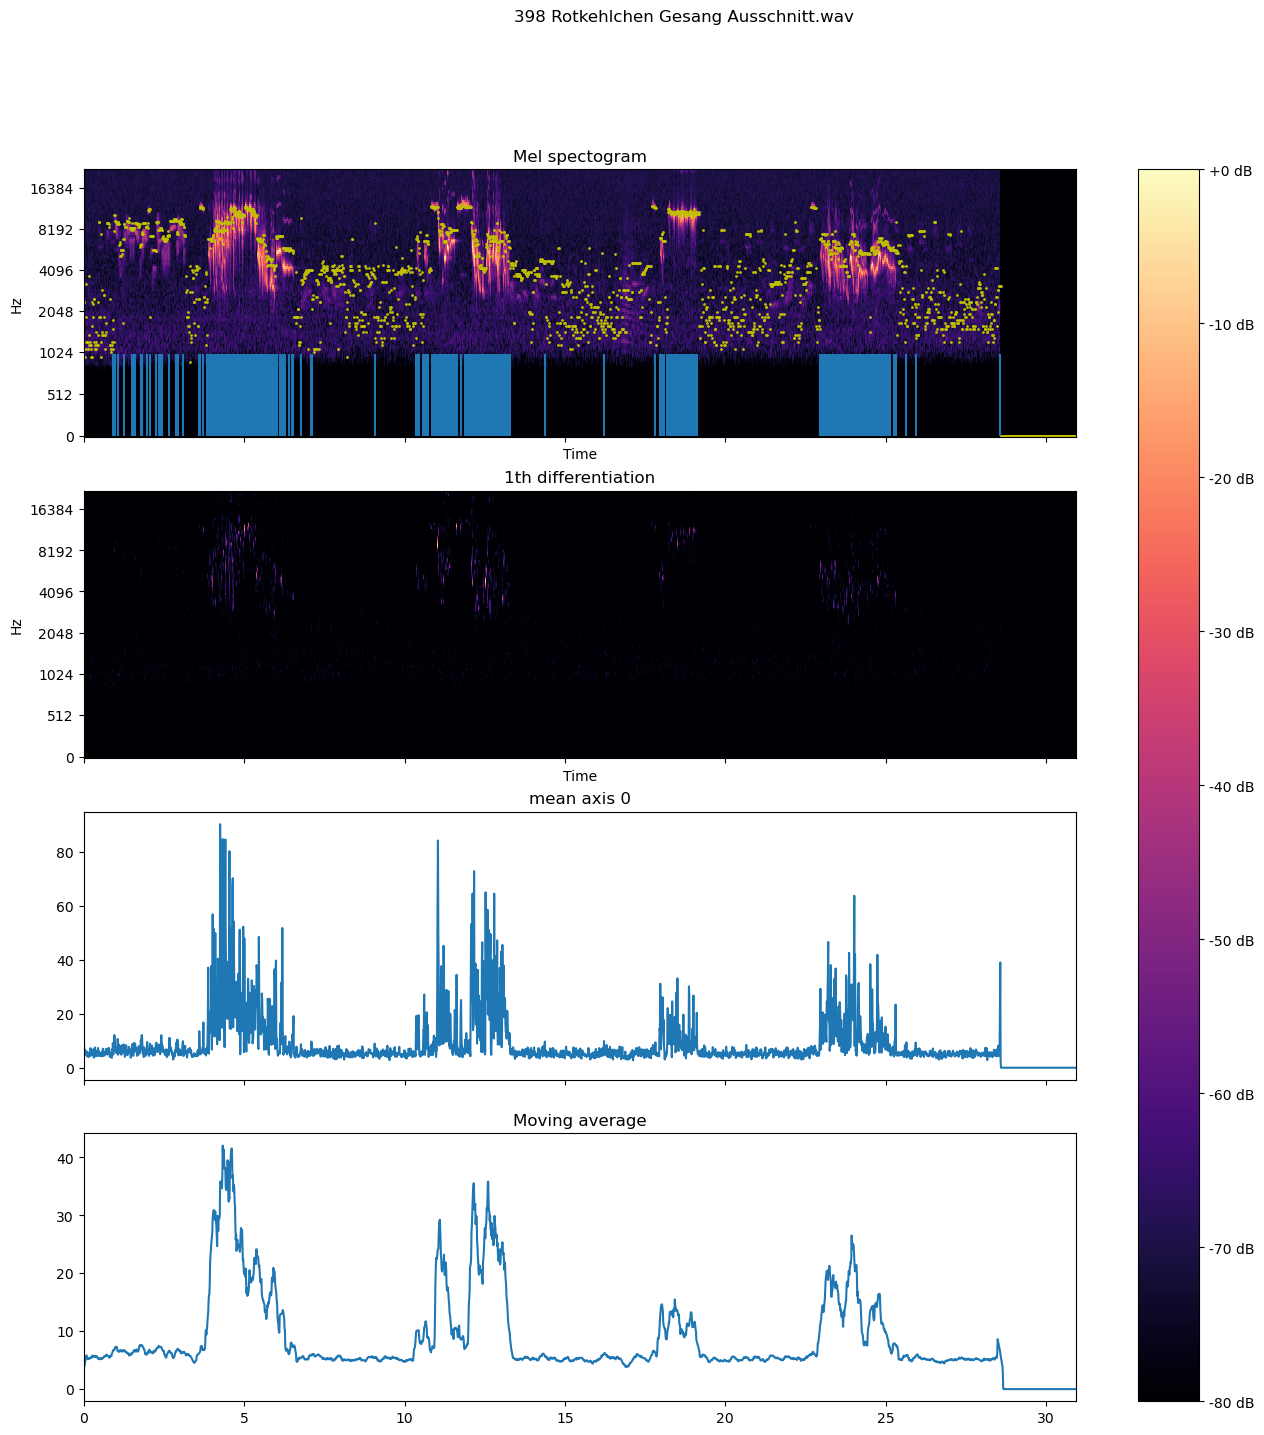

In [ ]:
for fname in os.listdir(SRC_PATH):
    if fname.lower().endswith(".wav"):
        audio_path = os.path.join(SRC_PATH, fname)
        audioWorker = AudioWorker(audio_path=audio_path)
        specs = audioWorker.get_mel_specs()
        audioWorker.plot_mel_spec(specs, save_fig=True)

In [465]:
specs = audioWorker.get_mel_specs()

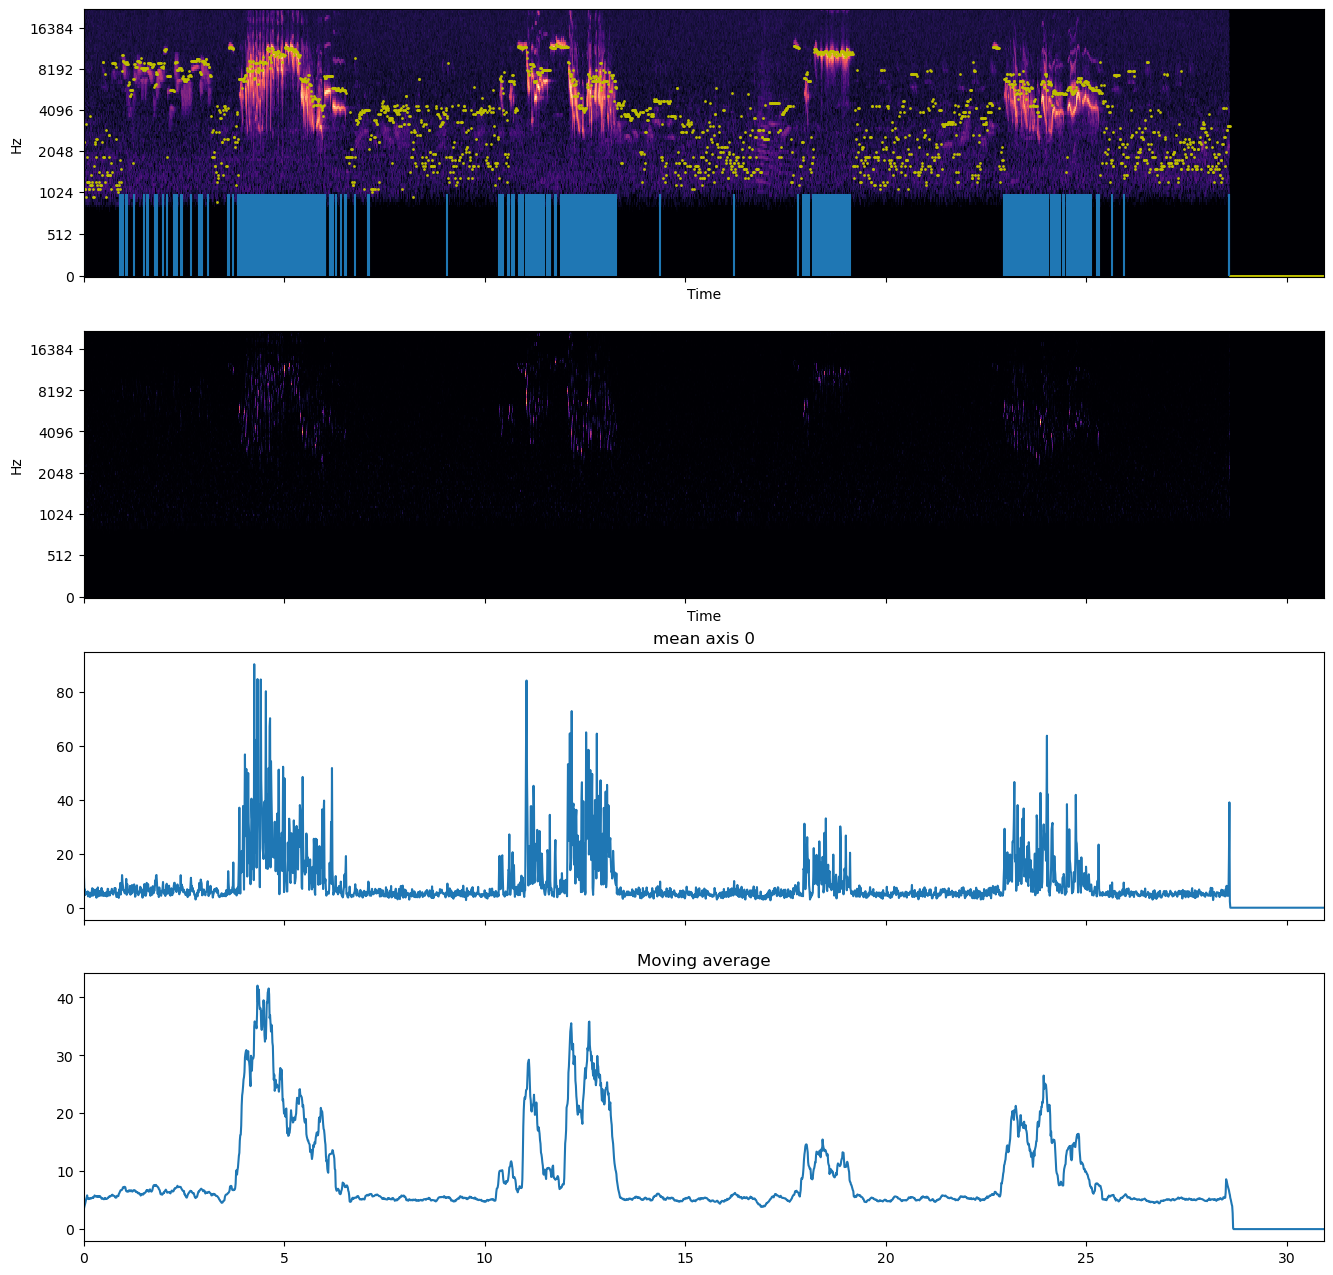